# AutoEncoder

Building an Autoencoder roughly based on the U-Net.

In [1]:
import numpy as np
np.random.seed(1993)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import datetime


## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

In [2]:
X = np.load("/scratch2/ttoebro/data/X_test_subset.npy")

In [3]:
X.shape

(1000, 256, 256, 1)

 Normalize data

In [4]:
Y = np.load('/scratch2/ttoebro/data/Y_test_subset.npy')

In [5]:
Y.shape

(1000, 256, 256, 1)

clean up the mess

In [6]:
gc.collect()

17

In [7]:
Y.shape

(1000, 256, 256, 1)

In [8]:

def conv_2(tensor_in, name_layer, n_filter, mode, is_start = False):
    if not is_start:
        tensor_in = tf.layers.batch_normalization(tensor_in,
                                                  axis = -1,
                                                  training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_1")
        
    x = tf.layers.conv2d(
        inputs = tensor_in,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_1")
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_2")
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_2")
    
    return x

def level_up(tensor_in, insert_layer, name_layer, n_filter, mode):
    #print("Shape before level up: " + str(tensor_in.shape))
    x = tf.layers.batch_normalization(tensor_in,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_1")
    
    x = tf.layers.conv2d_transpose(
            x,
            filters=n_filter,
            kernel_size=2,
            strides=2,
            padding = 'same',
            activation = tf.nn.relu,
            name=name_layer + "_upconv")
    #print("Shape after level up: " + str(x.shape))
    
    x = tf.concat([insert_layer, x], axis=-1, name=name_layer + "_insert")
    #print("Shape after putting in other vector: " + str(x.shape))
    
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_2")
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_1")
    #print("Shape after first conv in level up: " + str(x.shape))
    x = tf.layers.batch_normalization(x,
                                      axis = -1,
                                      training = (mode == tf.estimator.ModeKeys.TRAIN),
                                                  name = name_layer + "_bn_3")
    x = tf.layers.conv2d(
        inputs = x,
        filters = n_filter,
        kernel_size = [3, 3],
        padding = "same",
        activation= tf.nn.relu,
        name = name_layer + "_conv_2")
    #print("Shape after second conv in level up: " + str(x.shape))
    
    return x

# Create and train CNN

In [9]:
def AutoEncoder_model(features, labels, mode):
    
    # Input Tensor
    input_tensor = features['x']
    
    # Level 0
    level_0 = conv_2(input_tensor, "level_0", n_filter = 64, mode = mode, is_start = True)
    level_0_pool = tf.layers.max_pooling2d(level_0, (2, 2), strides=(2, 2), name="level_0_pooling")
    
    # Level 1
    level_1 = conv_2(level_0_pool, "level_1", n_filter = 128, mode = mode, is_start = False)
    level_1_pool = tf.layers.max_pooling2d(level_1, (2, 2), strides=(2, 2), name="level_1_pooling")
    
    # Level 2
    level_2 = conv_2(level_1_pool, "level_2", n_filter = 256, mode = mode, is_start = False)
    level_2_pool = tf.layers.max_pooling2d(level_2, (2, 2), strides=(2, 2), name="level_2_pooling")
    
    # Level 3
    level_3 = conv_2(level_2_pool, "level_3", n_filter = 512, mode = mode, is_start = False)
    level_3_pool = tf.layers.max_pooling2d(level_3, (2, 2), strides=(2, 2), name="level_3_pooling")
    
    # Level 4
    level_4 = conv_2(level_3_pool, "level_4", n_filter = 1024, mode = mode, is_start = False)
    level_4_pool = tf.layers.max_pooling2d(level_4, (2, 2), strides=(2, 2), name="level_4_pooling")
    
    # level 5
    level_5 = conv_2(level_4_pool, "level_5", n_filter = 1024, mode = mode, is_start = False)
    level_5_pool = tf.layers.max_pooling2d(level_5, (2, 2), strides=(2, 2), name="level_5_pooling")
    
    # level 6
    level_6 = conv_2(level_5_pool, "level_6", n_filter = 1024, mode = mode, is_start = False)
    
    # level 5
    level_5_up = level_up(level_6,level_5,"level_5_up" , n_filter = 1024, mode = mode)
    
    # level 4
    level_4_up = level_up(level_5_up,level_4,"level_4_up" , n_filter = 1024, mode = mode)
    
    # Level 3
    level_3_up = level_up(level_4_up,level_3,"level_3_up" , n_filter = 512, mode = mode)
    
    # Level 2
    level_2_up = level_up(level_3_up,level_2, "level_2_up" , n_filter = 256, mode = mode)
    
    # Level 1
    level_1_up = level_up(level_2_up,level_1, "level_1_up" , n_filter = 128, mode = mode)
    
    # Level 0
    level_0_up = level_up(level_1_up,level_0,"level_0_up"  , n_filter = 64, mode = mode)
    
    # final 
    final_layer = tf.layers.conv2d(
        inputs = level_0_up,
        filters = 1,
        kernel_size = [1, 1],
        padding = "same",
        activation = None,
        name = "final_layer")
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        # Output all learnable variables for tensorboard
        for var in tf.trainable_variables():
            name = var.name
            name = name.replace(':', '_')
            tf.summary.histogram(name, var)
        merged_summary = tf.summary.merge_all()
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            tf.summary.histogram("Summary_final_layer", final_layer)
            tf.summary.histogram("Summary_labels", labels)
            tf.summary.image("Input_Image", input_tensor)
            tf.summary.image("Output_Image", tf.abs(final_layer))
            tf.summary.image("True_Image", labels)
        
        #tf.summary.image("Input_Image", tf.slice(input_tensor,[0, -1, -1, -1]), max_outputs = 1)
        #tf.summary.image("Ouput_Image", tf.slice(final_layer, [0, -1, -1, -1]) + tf.abs(tf.minimum(tf.argmin(tf.slice(final_layer,[0, -1, -1, -1]), tf.constant(0, dype="float32")))), max_outputs = 1)
        #tf.summary.image("True_Image", tf.slice(labels, [0, -1, -1, -1]), max_outputs = 1)
    
    # Give output in prediction mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=final_layer)
    

    # Calculate Loss (for both Train and EVAL modes)
    # See that the residual learning is implemented here.
    loss = tf.losses.absolute_difference(labels = labels , predictions = final_layer)
    tf.summary.scalar("Value_Loss_Function", loss)
        
    # Configure Learning when training.
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            original_optimizer = tf.train.AdamOptimizer(learning_rate =  0.035)
            optimizer = tf.contrib.estimator.clip_gradients_by_norm(original_optimizer, clip_norm=5.0)
            train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)


Load train and test data

Create the estimator

In [10]:
runconf = tf.estimator.RunConfig(save_summary_steps=5, log_step_count_steps = 1)

In [11]:
AutoEncoder = tf.estimator.Estimator(config=runconf,
    model_fn=AutoEncoder_model, model_dir="/home/cloud/model/AutoEncoderV3"
    )

INFO:tensorflow:Using config: {'_model_dir': '/home/cloud/model/AutoEncoderV3', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb83b9aa898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [16]:
n_images = 150

In [17]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X[0:(n_images + 1),:,:,:]},
    y=Y[0:(n_images + 1),:,:,:],
    batch_size = 1,
    shuffle=False)
predict_results = AutoEncoder.predict(input_fn=predict_input_fn)

In [18]:
out = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/cloud/model/AutoEncoderV3/model.ckpt-126400


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [256] rhs shape= [128]
	 [[Node: save/Assign_45 = Assign[T=DT_FLOAT, _class=["loc:@level_1_up_bn_2/beta"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](level_1_up_bn_2/beta, save/RestoreV2:45)]]

Caused by op 'save/Assign_45', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-8688b9d7601b>", line 1, in <module>
    out = list(predict_results)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/estimator/estimator.py", line 499, in predict
    hooks=all_hooks) as mon_sess:
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 795, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 518, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 981, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 986, in _create_session
    return self._sess_creator.create_session()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 675, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 437, in create_session
    self._scaffold.finalize()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py", line 212, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 884, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1311, in __init__
    self.build()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1320, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 1357, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 803, in _build_internal
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 501, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 470, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py", line 162, in restore
    self.op.get_shape().is_fully_defined())
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/state_ops.py", line 281, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [256] rhs shape= [128]
	 [[Node: save/Assign_45 = Assign[T=DT_FLOAT, _class=["loc:@level_1_up_bn_2/beta"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](level_1_up_bn_2/beta, save/RestoreV2:45)]]


In [156]:
cur_pic = np.random.randint(0, n_images)

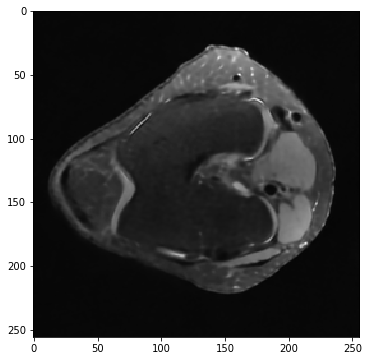

In [157]:
plt.figure(figsize = (6,6))
plt.imshow(out[cur_pic][:,:,0], cmap='gray')

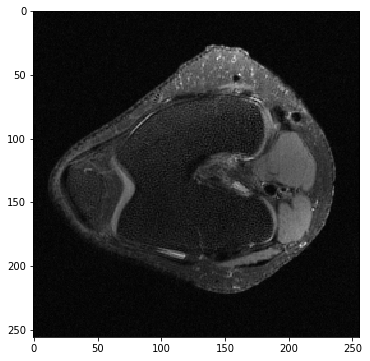

In [158]:
plt.figure(figsize = (6,6))
plt.imshow(Y[cur_pic,:,:,0], cmap='gray' )

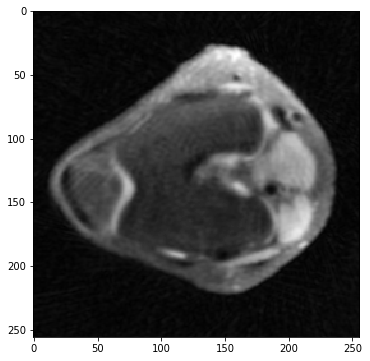

In [159]:
plt.figure(figsize = (6,6))
plt.imshow(X[cur_pic,:,:,0], cmap='gray' )

This is an original image. What does our network predict?